# CQC: Post-procesamiento

En este proyecto se busca clasificar solamente los caminos existentes en el archivo *caminos_lineas.geojson*. Para ello es necesario definir cuál de las clases predice mejor cada camino en la imagen. 

primero definimos agunas funciones que van a ser necesarias 

In [8]:
from shapely.geometry import shape
import fiona
import rasterio
import rasterio.mask
import operator
from shapely.geometry import box
import tifffile as tiff
from skimage.transform import resize
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import random
import numpy as np
from glob import glob
import os
from tqdm import tqdm
from rasterio.mask import raster_geometry_mask

## Post-procesamiento

La determinacion de la clase se separa en dos etapas. La primera, consiste en la determinar la mejor predicción dada una imagen (o chip). y la segunda en determinar la categoria mayoritaria de cada camino.

Para cada imagen, se recorre la prediccion de las cuatro categorias del modelo, y se la intercepta con el geojson del camino. 

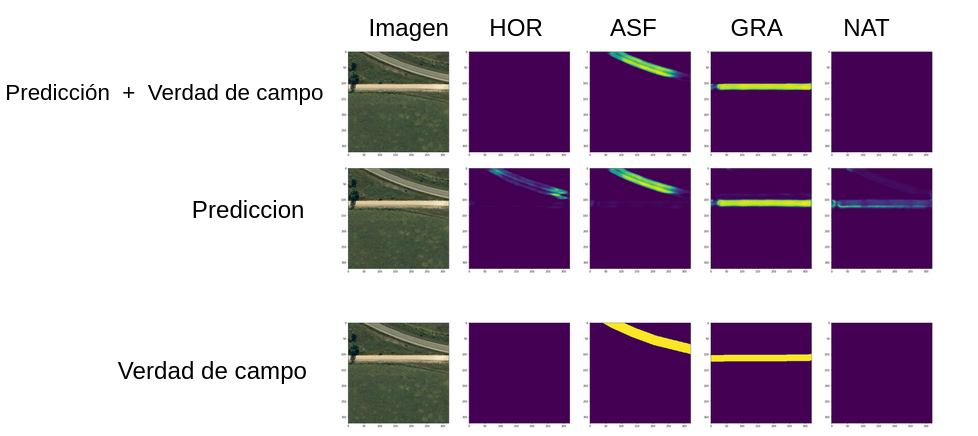

In [2]:
from IPython.display import Image
Image("/home/ro/meduy-cqc/img/ej_matched_prob.png")

En la Figura, la ultima fila corresponde con el geojson del camino. Este se intercepta con la prediccion del modelo para dicha imagen (fila dos), dando como resultado la primer fila. A partir de este se calcula cual de ellas posee la mayor probabilidad y esa se asigna como categoria del chip.

* Obs: Aqui vemos como es necesario que el geojson utilizado no sean lineales sino polígonos.

Luego la siguiente, evalua el las categorias generadas para todos los chips que componen a cada camino, y determina la categoria resultante como la *moda* de las prediccions que la componen
* Obs: *moda* valor que mas se repite

### Definicion de funciones 

La funcion *get_correct_prop* toma como input el resultado de la probabilidad interceptada con el camino y devuelve la categoria de mayor probabilidad

In [9]:
def get_correct_prop(mask_prob):
    
    clase = 'o' # otros
    
    #match the prediccion and the mask
    matched = dict([('HOR' , mask_prob[0,:,:].sum()),
                    ('ASF' , mask_prob[1,:,:].sum()),
                    ('GRA' , mask_prob[2,:,:].sum()),
                    ('NAT' , mask_prob[3,:,:].sum())
                    ])
    
    sorted_ = sorted(matched.items(), key=operator.itemgetter(1))

    max_probs = sorted_[3]
    
    if max_probs[1] != 0:
    
        clase = max_probs[0]
    
    return clase

La funcion *get_shape* toma la geometria y en caso de que sea invalida imprime los datos del poligono en cuestion

In [10]:
def get_shape(feat):
    try:
        return shape(feat['geometry'])
    except Exception:
        print("Invalid geometry in feature:", feat)
        return None

La funcion *shape_mask* genera el shape a partir de el shp de camnos general y considerar solo el area donde intercepta con el chip

In [11]:
def shape_mask(dataset, shapes):
    shape_mask, transform, window = raster_geometry_mask(dataset, shapes)
    return shape_mask

La funcion *create_new_roads_shapefile* toma como input el shp original de los caminos (las lineas), lo duplica y le agrega una clase: "clase" la cual posee la prediccion final de dicha categoria. y lo guarda en un nuevo geojson : "caminos_final_test.geojson"

In [20]:
def create_new_roads_shapefile(*, orig_path, dst_path, classes_by_feat):
    # create the output file path if it doesnt exist
    os.makedirs(dst_path, exist_ok=True)
    dst_p = dst_path + '/caminos_final_test_.geojson'
    # open original shp file
    with fiona.open(orig_path) as src:
  
        schema = src.schema.copy()
        schema['properties']['clase'] = 'str:3'

        #creates the destination geojson file with an extra column 
        with fiona.open(dst_p,
                        'w',
                        driver='GeoJSON',
                        crs=src.crs,
                        schema=src.schema) as dst:
            # Run over each line (or road) of the original shp file 
            for feat in tqdm(src):
                feat = feat.copy()
                if feat['id'] in classes_by_feat:
                    classes = classes_by_feat[feat['id']]
                    print (classes)
                    result = stats.mode(classes).mode[0]
                    print (result)
                    
                else:
                    result = '?'
                feat['properties']['clase'] = result
                dst.write(feat)

    return dst_path

### procesamiento


Se carga el shp de caminos 

In [15]:
!ls /home/ro/meduy-cqc/data/shp/


ls: cannot access '/home/ro/meduy-cqc/shp/': No such file or directory


In [16]:
with fiona.open("/home/ro/meduy-cqc/data/shp/caminos_pred.geojson") as src_camino:
    feats_and_shapes = [(f, get_shape(f)) for f in src_camino]

# List of (feature, shape)
feats_and_shapes = [(f, s) for f, s in feats_and_shapes if s]
# Dictionary of classes by feature id
classes_by_feat = {}

Invalid geometry in feature: {'type': 'Feature', 'id': '7782', 'properties': OrderedDict([('gid', 3349702), ('codigo', None), ('numero', None), ('nombre', None), ('depto', 'UYMA'), ('jurisdicc', 'J2'), ('categoria', 'T5'), ('sentido', 'S2'), ('carriles', 'R99'), ('calzada', 'C1'), ('fuente', 'F1'), ('observaci', 'urbano'), ('x_avance', 'T'), ('predec', None), ('fecha_des', None), ('historico', None)]), 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[]]]}}
Invalid geometry in feature: {'type': 'Feature', 'id': '11307', 'properties': OrderedDict([('gid', 3340402), ('codigo', 'UY0120001'), ('numero', 12), ('nombre', 'Dr. Luis Alberto de Herrera'), ('depto', 'UYCO'), ('jurisdicc', 'J1'), ('categoria', 'T3'), ('sentido', 'S2'), ('carriles', 'R2'), ('calzada', 'C1'), ('fuente', 'F1'), ('observaci', None), ('x_avance', 'T'), ('predec', None), ('fecha_des', None), ('historico', 'F')]), 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[]]]}}


Ejecuta la primera etapa de la prediccion

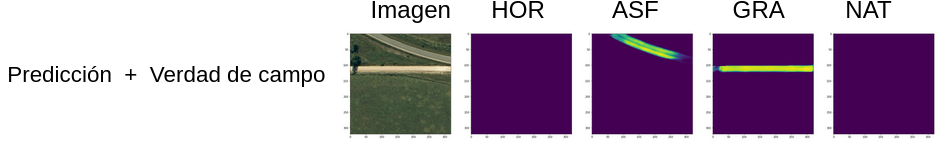

In [10]:
from IPython.display import Image
Image("/home/ro/meduy-cqc/img/ej_matched.png")

In [18]:
resultados_pred_path = os.path.join('./data/data_results', '400_400')
images = [os.path.basename(f) for f in sorted(glob(os.path.join(resultados_pred_path, '*.tif')))]
#H=10
#images = images[:H] 
#images = random.sample(images, H)

for img_file in tqdm(images):
    with rasterio.open(os.path.join(resultados_pred_path, img_file)) as src_prob: # c pred
        window = box(*src_prob.bounds)   
        win_feat_shapes = [(f, s) for f, s in feats_and_shapes if s.intersects(window)]


        out_mask = np.zeros(src_prob.shape,dtype=np.uint8) 

        for feat, win_shape in win_feat_shapes:
            prob_matched = src_prob.read()
            shape_mask, transform, window = raster_geometry_mask(src_prob, [win_shape])

            prob_matched = prob_matched.astype(np.float)
            prob_matched[:,shape_mask] = -1
           
            clase = get_correct_prop(prob_matched)
         
            
            # Add to class list for current feature
            if feat['id'] not in classes_by_feat:
                classes_by_feat[feat['id']] = []
            classes_by_feat[feat['id']].append(clase)

100%|██████████| 33559/33559 [45:15<00:00, 12.36it/s]


Ejecuta la segunda etapa de la prediccion 

In [21]:
from scipy import stats
original_shp_file = os.path.join('/home/ro/meduy-cqc/data/shp/', 'caminos_5382.geojson')
dst_path = os.path.join('./data/output_results_t', '400_400')

create_new_roads_shapefile(orig_path=original_shp_file, dst_path=dst_path, classes_by_feat=classes_by_feat)

  2%|▏         | 472/21224 [00:00<00:08, 2350.82it/s]

['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'ASF', 'HOR']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'ASF', 'ASF', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'HOR', 'HOR', 'HOR', 'HOR', 'GRA', 'NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'GRA']
HOR
['HOR', 'HOR', 'HOR', 'GRA', 'HOR', 'ASF', 'ASF']
HOR
['NAT', 'NAT']
NAT
['HOR', 'NAT']
HOR
['GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['HOR', 'NAT', 'NAT'

  4%|▍         | 892/21224 [00:00<00:09, 2215.58it/s]

['HOR', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT']
GRA
['GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'HOR', 'ASF', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'GRA', 'NAT']
NAT
['NAT', 'NAT']
NAT
['GRA']
GRA
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT']
NAT
['HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'ASF', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR']
HOR
['NAT', 'HOR']
HOR
['GRA', 'G

  6%|▌         | 1318/21224 [00:00<00:09, 2091.67it/s]

['GRA', 'NAT']
GRA
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'GRA', 'NAT']
NAT
['NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT

  8%|▊         | 1754/21224 [00:00<00:09, 2125.76it/s]

GRA
['GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'HOR', 'HOR', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA']
GRA
['GRA', 'NAT']
GRA
['NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 

 11%|█▏        | 2393/21224 [00:01<00:08, 2130.68it/s]

['GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT']
NAT
['HOR', 'NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR']
HOR
['GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'HOR', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'HOR', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT']
GRA
['GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'HOR']
NAT
['NAT', 'NAT', 'NAT']
NAT
['HOR', 'NAT']
HOR
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR']
NAT
['GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'G

 13%|█▎        | 2828/21224 [00:01<00:08, 2132.25it/s]

['GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT']
GRA
['NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'GRA', 'NAT']
GRA
['GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA']
GRA
['HOR', 'NAT', 'NAT', 'NAT', 'HOR', 'HOR', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'NAT', 'HOR', 'NAT', 'NAT', 'HOR', 'NAT', 'HOR', 'HOR', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'HOR', 'NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'NAT', 'NAT', 'NAT', 'HOR', 'HOR', 'NAT', 'NAT', 'NAT', 'HOR', 'HOR', 'NAT', 'HOR', 'HOR', 'HOR', 'GRA', 'HOR']
NAT
['NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NA

 16%|█▌        | 3308/21224 [00:01<00:07, 2261.35it/s]

['NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'GRA', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'HOR', 'NAT', 'HOR']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'GRA', 'NAT']
NAT
['GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT']
NAT
['HOR', 'GRA', 'NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'GRA', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'GRA', 'HOR', 'NAT', 'GRA', 'HOR', 'HOR', 'HOR', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'HOR', 'HOR', 'NAT', 'NAT', 'HOR', 'HOR', 'GRA', 'GRA', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', '

 18%|█▊        | 3769/21224 [00:01<00:07, 2200.74it/s]

['NAT', 'GRA', 'GRA']
GRA
['NAT']
NAT
['NAT', 'NAT', 'HOR', 'NAT', 'ASF', 'HOR', 'NAT', 'GRA', 'GRA', 'HOR', 'HOR', 'HOR', 'NAT', 'HOR', 'HOR']
HOR
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT']
NAT
['HOR', 'HOR', 'HOR']
HOR
['GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'NAT', 'HOR', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'GRA', 'HOR', 'GRA', 'NAT', 'NAT', 

 21%|██        | 4441/21224 [00:02<00:07, 2208.51it/s]

['HOR', 'NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'NAT', 'HOR']
HOR
['HOR']
HOR
['NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'ASF', 'GRA', 'NAT']
NAT
['HOR', 'NAT', 'ASF', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'NAT', 'HOR', 'HOR', 'NAT', 'HOR', 'HOR', 'HOR', 'ASF', 'HOR', 'HOR', 'ASF', 'HOR', 'HOR', 'HOR', 'HOR', 'GRA', 'HOR', 'NAT', 'ASF', 'HOR', 'NAT', 'NAT', 'NAT', 'HOR', 'HOR', 'NAT', 'HOR', 'HOR', 'NAT', 'NAT', 'HOR', 'HOR', 'NAT', 'HOR', 'ASF', 'HOR', 'ASF', 'NAT', 'NAT', 'ASF', 'NAT']
HOR
['GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'HOR', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'HOR', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT']
GRA
['NAT', 'NAT', '

 23%|██▎       | 4883/21224 [00:02<00:07, 2190.60it/s]

['HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'NAT', 'HOR', 'NAT', 'HOR', 'HOR', 'HOR', 'GRA', 'HOR', 'HOR', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'HOR', 'NAT', 'HOR', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'ASF', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'HOR', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'ASF', 'HOR', 'ASF', 'HOR', 'NAT', 'ASF', 'NAT', 'ASF', 'NAT', 'ASF', 'NAT', 'ASF', 'GRA', 'ASF', 'NAT', 'NAT', 'ASF', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'ASF', 'ASF', 'ASF', 'ASF', 'ASF', 'NAT', 'ASF', 'ASF', 'ASF', 'ASF', 'ASF', 'HOR', 'NAT', 'HOR', 'ASF', 'NAT', 'NAT', 'NAT', 'ASF', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'ASF', 'NAT', 'NAT', 'ASF', 'NAT', 'ASF', 'ASF', 'HOR', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'ASF', 'ASF', 'NAT', 'ASF', 'ASF', 'NAT', 'ASF', 'NAT', 'ASF', 'ASF', 'NAT', 'ASF'

 25%|██▌       | 5327/21224 [00:02<00:07, 2205.27it/s]

['HOR', 'HOR', 'GRA', 'NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'HOR', 'HOR', 'GRA', 'GRA', 'GRA', 'GRA', 'HOR', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'HOR', 'GRA', 'GRA', 'HOR', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'HOR', 'HOR', 'HOR', 'GRA']
NAT
['NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA']
GRA
['NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT',

 27%|██▋       | 5767/21224 [00:02<00:07, 2153.89it/s]

HOR
['NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'NAT', 'NAT', 'HOR']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'ASF', 'NAT', 'NAT', 'NAT', 'HOR']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT']
NAT
['NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT',

 30%|███       | 6447/21224 [00:02<00:06, 2225.97it/s]

['GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR']
GRA
['NAT', 'HOR', 'NAT', 'HOR', 'NAT', 'NAT', 'HOR', 'HOR', 'HOR']
HOR
['NAT']
NAT
['HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT',

 33%|███▎      | 6906/21224 [00:03<00:06, 2228.62it/s]

['HOR', 'GRA', 'GRA', 'HOR', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'HOR', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'ASF', 'ASF', 'HOR', 'HOR', 'GRA', 'GRA', 'GRA', 'GRA', 'HOR', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'HOR', 'GRA', 'HOR', 'ASF', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'HOR', 'NAT', 'GRA', 'NAT', 'HOR', 'HOR', 'HOR', 'GRA', 'HOR', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'HOR', 'HOR', 'HOR', 'GRA', 'HOR', 'GRA', 'HOR', 'GRA', 'ASF', 'GRA', 'GRA']
GRA
['GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA']
GRA
['GRA', 'HOR', 'GRA', 'NAT', 'GRA', 'GRA', 'HOR', 'HOR', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'HOR', 'HOR', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'HOR', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'N

 35%|███▍      | 7345/21224 [00:03<00:06, 2131.16it/s]

GRA
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT']
NAT
['HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'ASF', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'ASF', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'HOR', 'NAT', 'HOR', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'ASF', 'NAT', 'NAT', 'HOR', 'ASF', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'ASF', 'NAT', 'GRA', 'NAT', 'ASF', 'NAT', 'NA

 37%|███▋      | 7813/21224 [00:03<00:06, 2233.50it/s]

['NAT', 'NAT', 'HOR', 'HOR', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'HOR', 'NAT', 'GRA', 'GRA', 'HOR', 'GRA', 'GRA', 'GRA']
NAT
['HOR']
HOR
['GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'ASF', 'GRA', 'ASF', 'HOR', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA']
GRA
['HOR']
HOR
['NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'HOR', 'GRA', 'GRA', 'HOR', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']

 39%|███▉      | 8259/21224 [00:03<00:06, 2126.11it/s]

['NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA']
NAT
['GRA', 'GRA', 'HOR', 'HOR', 'HOR', 'HOR', 'ASF', 'ASF', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT']
HOR
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'HOR', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA']
NAT
['HOR']
HOR
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['HOR', 'HOR', 'HOR']
HOR
['NAT', 'NAT']
NAT
['HOR', 'HOR']
HOR
['NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'N

 42%|████▏     | 8915/21224 [00:04<00:05, 2120.17it/s]

['GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA']
NAT
['GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT']
GRA
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'HOR', 'GRA', 'GRA', 'NAT', 'GRA', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'GRA', 'GRA', 'NAT', 'GRA']
GRA
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['ASF', 'HOR', 'GRA', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'ASF']
NAT
['HOR', 'HOR', 'HOR']
HOR
['NAT', 'NAT', 'GRA', 'NAT', 'HOR']
NAT
['GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA']
GRA
['NAT']
NAT
['GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT']
GRA
['NAT', 'HOR']
HOR
['HOR', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT']
NAT
['NAT', 'NAT', 'NAT'

 44%|████▍     | 9380/21224 [00:04<00:05, 2153.10it/s]

['NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA']
GRA
['NAT']
NAT
['GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT']
NAT
['NAT', 'NAT']
NAT
['GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA']
GRA
['GRA', 'NAT', 'GRA', 'NAT']
GRA
['HOR', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA']
NAT
['NAT', 'GRA', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['HOR', 'HOR', 'HOR', 'GRA', 'HOR', 'HOR', 'HOR', 'HOR']
HOR
['HOR', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA'

 46%|████▌     | 9814/21224 [00:04<00:05, 2150.01it/s]

['NAT', 'NAT']
NAT
['GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA']
GRA
['GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'HOR', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'HOR', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA']
GRA
['NAT', 'NAT', 'NAT']
NAT
['GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA']
GRA
['GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'HOR', 'GRA']
GRA
['GRA']
GRA
['GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'HOR', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 

 49%|████▉     | 10481/21224 [00:04<00:04, 2163.48it/s]

['GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA']
GRA
['GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA']
NAT
['HOR', 'HOR', 'HOR', 'HOR', 'GRA', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'GRA']
HOR
['GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'HOR', 'GRA', 'GRA', 'HOR', 'GRA', 'GRA', 'HOR', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'GRA', 'NAT']
GRA
['GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'HOR', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GR

 51%|█████▏    | 10929/21224 [00:05<00:04, 2123.94it/s]

['NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR']
HOR
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'HOR', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT']
NAT
['NAT', 'GRA', 'GRA', 'GRA', 'HOR', 'GRA', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'HOR

 54%|█████▎    | 11370/21224 [00:05<00:04, 2159.06it/s]

['GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA']
GRA
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT

 57%|█████▋    | 12027/21224 [00:05<00:04, 2152.87it/s]

['NAT', 'NAT']
NAT
['NAT', 'GRA', 'HOR', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT']
NAT
['NAT', 'NAT']
NAT
['GRA', 'ASF', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA',

 59%|█████▉    | 12471/21224 [00:05<00:04, 2161.32it/s]

['HOR', 'HOR']
HOR
['GRA', 'HOR', 'GRA', 'NAT', 'GRA']
GRA
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', '

 62%|██████▏   | 13145/21224 [00:06<00:03, 2201.34it/s]

['NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'HOR', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT']
NAT
['ASF', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'HOR']
NAT
['HOR']
HOR
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA']
NAT
['GRA', 'GRA']
GRA
['HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'GRA', 'HOR', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT']
NAT
['GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'GR

 64%|██████▍   | 13590/21224 [00:06<00:03, 2189.77it/s]

['NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT']
NAT
['NAT']
NAT
['NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'GRA', 'HOR', 'GRA', 'NAT', 'G

 66%|██████▋   | 14069/21224 [00:06<00:03, 2265.16it/s]

NAT
['NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'HOR', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT'

 69%|██████▊   | 14549/21224 [00:06<00:02, 2275.65it/s]

['NAT']
NAT
['GRA', 'NAT', 'ASF', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'HOR', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'NAT']
GRA
['NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'HOR', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'ASF', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT']
GRA
['HOR', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'HOR', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'HOR', 'HOR', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'HOR', 'NAT', 'HOR', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'HOR', 'NAT', 'GRA', 'GRA', 'GRA']
GRA
['HOR']
HOR
['NAT']
NAT
['GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'HOR']
GRA
['NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'GRA', 'GRA', 'NAT']
GRA
['NAT', 'NAT', 'NAT', 'NAT

 71%|███████   | 15004/21224 [00:06<00:02, 2180.20it/s]

['HOR', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT']
GRA
['GRA', 'HOR', 'GRA', 'HOR', 'NAT', 'GRA', 'HOR', 'NAT', 'HOR', 'GRA', 'HOR', 'HOR', 'HOR', 'HOR', 'ASF', 'HOR', 'HOR', 'HOR', 'HOR', 'ASF', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'GRA', 'HOR', 'HOR', 'HOR', 'GRA', 'HOR', 'HOR', 'HOR', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'NAT', 'HOR', 'HOR', 'NAT', 'NAT', 'NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR']
HOR
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA

 73%|███████▎  | 15444/21224 [00:07<00:02, 2145.05it/s]

['NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'HOR', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'ASF', 'GRA', 'GRA', 'GRA', 'HOR', 'GRA', 'GRA']
GRA
['HOR', 'HOR', 'GRA', 'HOR', 'HOR', 'GRA', 'NAT', 'ASF', 'NAT', 'ASF', 'NAT', 'ASF', 'ASF', 'ASF', 'HOR', 'ASF', 'HOR', 'ASF', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'GRA', 'HOR', 'HOR', 'HOR', 'HOR', 'GRA', 'NAT', 'HOR', 'HOR', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'NAT', 'ASF', 'ASF', 'NAT', 'ASF', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'HOR', 'HOR', 'NAT', 'NAT', 'ASF', 'NAT', 'ASF', 'GRA', 'GRA', 'GRA', 'GRA', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA']
NAT
['NAT', 'NAT']
NAT
['NAT', 'HOR', 'HOR', 'NAT', 'GRA', 'HOR', 'NAT']
HOR
['NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NA

 76%|███████▌  | 16104/21224 [00:07<00:02, 2172.19it/s]

['GRA', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'ASF', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA']
GRA
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'HOR', 'NAT']
NAT
['NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT']
NAT
['HOR']
HOR
['NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'HOR', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'GRA', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NA

 78%|███████▊  | 16552/21224 [00:07<00:02, 2209.67it/s]

HOR
['NAT', 'NAT']
NAT
['GRA', 'GRA', 'ASF', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'HOR', 'NAT', 'ASF', 'ASF', 'GRA', 'GRA', 'ASF', 'ASF']
GRA
['NAT', 'NAT', 'NAT', 'ASF', 'NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'NAT', 'NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'NAT', 'HOR', 'HOR', 'HOR']
HOR
['GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR']
NAT
['HOR']
HOR
['HOR', 'NAT', 'NAT', 'NAT']
NAT
['NAT']
NAT
['GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT']
NAT
['HOR', 'HOR']
HOR
['GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'HOR', 'HOR', 'NAT', 'HOR', 'HOR', 'HOR']
HOR
['NAT', 'NAT', 'NAT', 'GRA']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'GRA', 'NAT', 'HOR', 'GRA

 80%|████████  | 17006/21224 [00:07<00:01, 2232.17it/s]

['GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA']
GRA
['HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'HOR', 'GRA', 'HOR', 'HOR', 'NAT', 'HOR', 'HOR', 'NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'ASF', 'HOR', 'NAT', 'HOR', 'NAT', 'NAT', 'HOR']
HOR
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', '

 82%|████████▏ | 17451/21224 [00:08<00:01, 2136.00it/s]

NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'HOR', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['HOR', 'GRA', 'HOR']
HOR
['GRA', 'HOR', 'GRA', 'NAT', 'GRA', 'NAT']
GRA
['HOR']
HOR
['NAT', 'HOR', 'HOR', 'HOR', 'NAT', 'HOR']
HOR
['GRA', 'HOR', 'GRA', 'HOR']
GRA
['NAT', 'NAT', 'NAT', 'HOR', 'HOR']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA']
NAT
['NAT', 'NA

 84%|████████▍ | 17908/21224 [00:08<00:01, 2180.72it/s]

['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['ASF', 'ASF', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'ASF', 'ASF', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'ASF', 'NAT', 'NAT', 'GRA', 'NAT']
NAT
['NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT',

 88%|████████▊ | 18571/21224 [00:08<00:01, 2176.54it/s]

['NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT']
NAT
['GRA', 'NAT']
GRA
['GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA']
NAT
['HOR', 'GRA', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'HOR', 'NAT', 'GRA', 'GRA', 'ASF', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT

 90%|████████▉ | 19007/21224 [00:08<00:01, 2149.45it/s]

['NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'HOR', 'GRA', 'GRA', 'HOR', 'HOR', 'NAT', 'HOR', 'GRA', 'NAT', 'HOR', 'HOR', 'GRA', 'GRA', 'ASF', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'HOR', 'GRA', 'GRA', 'NAT', 'GRA', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'HOR', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT']


 92%|█████████▏| 19438/21224 [00:08<00:00, 2143.60it/s]

HOR
['GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'HOR', 'GRA', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'ASF']
GRA
['NAT', 'HOR', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR']
NAT
['GRA', 'NAT']
GRA
['NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'HOR', 'HOR', 'HOR', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 

 94%|█████████▍| 19923/21224 [00:09<00:00, 2201.27it/s]

['NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT']
NAT
['GRA']
GRA
['ASF', 'NAT', 'NAT', 'NAT', 'NAT', 'ASF', 'HOR', 'HOR', 'GRA']
NAT
['NAT', 'NAT']
NAT
['ASF', 'HOR', 'ASF', 'ASF', 'ASF', '

 96%|█████████▌| 20393/21224 [00:09<00:00, 2263.97it/s]

['NAT', 'NAT']
NAT
['NAT']
NAT
['ASF', 'ASF', 'ASF', 'ASF', 'ASF', 'ASF']
ASF
['HOR', 'NAT']
HOR
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'HOR', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT']
NAT
['HOR', 'HOR', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'GRA', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'GRA', 'GRA', 'GRA', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'GRA', 'NAT', 'GRA', 'HOR', 'GRA', 'NAT', 'NA

 99%|█████████▉| 21065/21224 [00:09<00:00, 2130.64it/s]

['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'HOR', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['GRA', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['HOR', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'HOR', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'GRA', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA']
NAT
['NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'GRA', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'ASF', 'NAT', '

100%|██████████| 21224/21224 [00:09<00:00, 2176.90it/s]

['NAT']
NAT
['NAT', 'NAT']
NAT
['HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'GRA', 'HOR', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT', 'NAT']
NAT
['NAT']
NAT


'./data/output_results_t/400_400'